In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["owslib"]
_colab_install_missing_deps(deps)

# Using NCEI geoportal REST API to collect information about IOOS Regional Association archived data

Created: 2017-06-12

IOOS regional associations archive their non-federal observational data with NOAA's National Center for Environmental Information (NCEI). In this notebook we will use the [RESTful](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) services of the [NCEI geoportal](https://www.ncei.noaa.gov/metadata/geoportal) to collect metadata from the archive packages found in the NCEI archives. The metadata information are stored in [ISO 19115-2](https://wiki.earthdata.nasa.gov/display/NASAISO/ISO+19115-2) xml files which the NCEI geoportal uses for discovery of Archival Information Packages (AIPs). This example uses the ISO metadata records to display publication information as well as plot the time coverage of each AIP at NCEI which meets the search criteria.

First we update the namespaces dictionary from owslib to include the appropriate namespace reference for gmi and gml.

In [2]:
from owslib.iso import namespaces

# Append gmi namespace to namespaces dictionary.
namespaces.update({"gmi": "http://www.isotc211.org/2005/gmi"})
namespaces.update({"gml": "http://www.opengis.net/gml/3.2"})
del namespaces[None]

## Now we select a Regional Association and platform

This is where the user identifies the Regional Association and the platform type they are interested in. Change the RA acronym to the RA of interest. The user can also omit the Regional Association, by using `None`, to collect metadata information about all IOOS non-Federal observation data archived through the NCEI-IOOS pipeline.

The options for platform include: `"HF Radar"`, `"Glider"`, and `"FIXED PLATFORM"`.

In [3]:
# Select RA, this will be the acronym for the RA or None if you want to search across all RAs
ra = "NANOOS"

# Identify the platform.
platform = (
    '"FIXED PLATFORM"'  # Options include: None, "HF Radar", "Glider", "FIXED PLATFORM"
)

## Next we generate a geoportal query and georss feed

To find more information about how to compile a geoportal query, have a look at [REST API Syntax](https://github.com/Esri/geoportal-server/wiki/REST-API-Syntax) and the [NCEI Search Tips](https://www.ncei.noaa.gov/metadata/geoportal/#aboutPanel) for the [NCEI geoportal](https://www.ncei.noaa.gov/metadata/geoportal/#searchPanel). The example provided is specific to the NCEI-IOOS data pipeline project and only searches for non-federal timeseries data collected by each Regional Association.

The query developed here can be updated to search for any Archival Information Packages at NCEI, therefore the user should develop the appropriate query using the [NCEI Geoportal](https://www.ncei.noaa.gov/metadata/geoportal/#searchPanel) and update this portion of the code to identify the REST API of interest.

In [4]:
try:
    from urllib.parse import quote
except ImportError:
    from urllib import quote

# Generate geoportal query and georss feed.

# Base geoportal url.
baseurl = "https://www.ncei.noaa.gov/" "metadata/geoportal/opensearch" "?q="

# Identify the Regional Association
if ra is None:
    reg_assoc = ""
else:
    RAs = {
        "AOOS": "Alaska Ocean Observing System",
        "CARICOOS": "Caribbean Coastal Ocean Observing System",
        "CeNCOOS": "Central and Northern California Coastal Ocean Observing System",
        "GCOOS": "Gulf of Mexico Coastal Ocean Observing System",
        "GLOS": "Great Lakes Observing System",
        "MARACOOS": "Mid-Atlantic Regional Association Coastal Ocean Observing System",
        "NANOOS": "Northwest Association of Networked Ocean Observing Systems",
        "NERACOOS": "Northeastern Regional Association of Coastal Ocean Observing System",
        "PacIOOS": "Pacific Islands Ocean Observing System",
        "SCCOOS": "Southern California Coastal Ocean Observing System",
        "SECOORA": "Southeast Coastal Ocean Observing Regional Association",
    }
    reg_assoc = (
        f'(dataThemeinstitutions_s:"{RAs[ra]}" dataThemeprojects_s:"{RAs[ra]} ({ra})")'
    )

# Identify the project.
project = (
    '"Integrated Ocean Observing System Data Assembly Centers Data Stewardship Program"'
)

# Identify the amount of records and format of the response: 1 to 1010 records.
records = "&start=1&num=1010"

# Identify the format of the response: georss.
response_format = "&f=csv"

if platform is not None:
    reg_assoc_plat = quote(reg_assoc + " AND" + platform)
else:
    reg_assoc_plat = quote(reg_assoc)

# Combine the URL.
url = "{}{}{}{}".format(
    baseurl,
    reg_assoc_plat,
    "&filter=dataThemeprojects_s:",
    quote(project) + records + response_format,
)

print(f"Identified response format:\n{url}")
print(
    "\nSearch page response:\n{}".format(url.replace(response_format, "&f=searchPage"))
)

Identified response format:
https://www.ncei.noaa.gov/metadata/geoportal/opensearch?q=%28dataThemeinstitutions_s%3A%22Northwest%20Association%20of%20Networked%20Ocean%20Observing%20Systems%22%20dataThemeprojects_s%3A%22Northwest%20Association%20of%20Networked%20Ocean%20Observing%20Systems%20%28NANOOS%29%22%29%20AND%22FIXED%20PLATFORM%22&filter=dataThemeprojects_s:%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22&start=1&num=1010&f=csv

Search page response:
https://www.ncei.noaa.gov/metadata/geoportal/opensearch?q=%28dataThemeinstitutions_s%3A%22Northwest%20Association%20of%20Networked%20Ocean%20Observing%20Systems%22%20dataThemeprojects_s%3A%22Northwest%20Association%20of%20Networked%20Ocean%20Observing%20Systems%20%28NANOOS%29%22%29%20AND%22FIXED%20PLATFORM%22&filter=dataThemeprojects_s:%22Integrated%20Ocean%20Observing%20System%20Data%20Assembly%20Centers%20Data%20Stewardship%20Program%22&start=1&num=1010&f=searchPage


## Time to query the portal and parse out the csv response

Here we are opening the specified REST API and parsing it into a string. Then, since we identified it as a csv format above, we parse it using the Pandas package. We also split the Data_Date_Range column into two columns, `data_start_date` and `data_end_date` to have that useful information available.

In [5]:
import numpy as np
import pandas as pd

df = pd.read_csv(url)

df[["data_start_date", "data_end_date"]] = df["Data_Date_Range"].str.split(
    " to ", expand=True
)
df["data_start_date"] = pd.to_datetime(df["data_start_date"])
df["data_end_date"] = pd.to_datetime(df["data_end_date"]) + pd.Timedelta(
    np.timedelta64(1, "ms")
)

df.head()

,Id,Title,Description,West,South,East,North,Link_Xml,Link_1,Link_2,Link_3,Link_4,Data_Date_Range,Date_Published,data_start_date,data_end_date
0,gov.noaa.nodc:0162194,Oceanographic data collected from Hammond Tide...,NaN,-123.95167,46.20267,-123.95167,46.20267,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2005-06-24T00:00:00Z to 2013-02-08T23:59:59.999Z,2017-03-21T00:00:00Z,2005-06-24 00:00:00+00:00,2013-02-09 00:00:00+00:00
1,gov.noaa.nodc:0162195,Oceanographic data collected from SATURN River...,NaN,-123.87195,46.23498,-123.87195,46.23498,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2009-06-06T00:00:00Z to 2010-10-22T23:59:59.999Z,2017-03-21T00:00:00Z,2009-06-06 00:00:00+00:00,2010-10-23 00:00:00+00:00
2,gov.noaa.nodc:0162190,Oceanographic data collected from Tenasillahe ...,NaN,-123.46828,46.23763,-123.46828,46.23763,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2004-01-23T00:00:00Z to 2011-11-17T23:59:59.999Z,2017-03-20T00:00:00Z,2004-01-23 00:00:00+00:00,2011-11-18 00:00:00+00:00
3,gov.noaa.nodc:0162191,Oceanographic data collected from Woody Island...,NaN,-123.53420,46.25212,-123.53420,46.25212,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,1997-02-07T00:00:00Z to 2021-09-01T23:59:59.999Z,2017-03-20T00:00:00Z,1997-02-07 00:00:00+00:00,2021-09-02 00:00:00+00:00
4,gov.noaa.nodc:0162176,Oceanographic data collected from Jetty A by C...,NaN,-124.03168,46.26712,-124.03168,46.26712,http://www.ncei.noaa.gov/metadata/geoportal/re...,NaN,NaN,NaN,NaN,2003-07-20T00:00:00Z to 2016-02-04T23:59:59.999Z,2017-03-20T00:00:00Z,2003-07-20 00:00:00+00:00,2016-02-05 00:00:00+00:00


Now, lets pull out all the ISO metadata record links and print them out so the user can browse to the metadata record and look for what items they might be interested in.

In [6]:
# parse the csv response

print(f"Found {len(df)} record(s)")
for index, row in df.iterrows():
    print("ISO19115-2 record:", row["Link_Xml"])  # URL to ISO19115-2 record.
    print(
        "NCEI dataset metadata page: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id="
        + row["Id"]
    )
    print("\n")

Found 31 record(s)
ISO19115-2 record: http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0162194/xml
NCEI dataset metadata page: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0162194


ISO19115-2 record: http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0162195/xml
NCEI dataset metadata page: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0162195


ISO19115-2 record: http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0162190/xml
NCEI dataset metadata page: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0162190


ISO19115-2 record: http://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0162191/xml
NCEI dataset metadata page: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0162191


ISO19115-2 record: http://www.ncei.noaa.gov/metadata/geoportal/rest/m

## Let's collect what we have found

Now that we have all the ISO metadata records we are interested in, it's time to do something fun with them. In this example we want to generate a timeseries plot of the data coverage for the "Southern California Coastal Ocean Observing System" stations we have archived at NCEI.

First we need to collect some information. We loop through each iso record to collect metadata information about each package. The example here shows how to collect the following items:

1. NCEI Archival Information Package (AIP) Accession ID (7-digit Accession Number)
1. The first date the archive package was published.
1. The platform code identified from the provider.
1. The version number and date it was published.
1. The current AIP size, in MB.

There are plenty of other metadata elements to collect from the ISO records, so we recommend browsing to one of the records and having a look at the items of interest to your community.

In [7]:
# Process each iso record.
%matplotlib inline

import xml.etree.ElementTree as ET
from urllib.request import urlopen

from owslib import util

df[
    [
        "provider_platform_name",
        "NCEI_accession_number",
        "package_size_mb",
        "submitter",
        "version_info",
    ]
] = ""

# For each accession in response.
for url in df["Link_Xml"]:
    iso = urlopen(url)
    iso_tree = ET.parse(iso)
    root = iso_tree.getroot()

    vers_dict = dict()

    # Collect Publication date information.
    date_path = (
        ".//"
        "gmd:identificationInfo/"
        "gmd:MD_DataIdentification/"
        "gmd:citation/"
        "gmd:CI_Citation/"
        "gmd:date/"
        "gmd:CI_Date/"
        "gmd:date/gco:Date"
    )
    # First published date.
    pubdate = root.find(date_path, namespaces)
    print(f"\nFirst published date = {util.testXMLValue(pubdate)}")

    # Data Temporal Coverage.
    temporal_extent_path = (
        ".//"
        "gmd:temporalElement/"
        "gmd:EX_TemporalExtent/"
        "gmd:extent/"
        "gml:TimePeriod"
    )

    beginPosition = root.find(
        temporal_extent_path + "/gml:beginPosition", namespaces
    ).text
    endPosition = root.find(temporal_extent_path + "/gml:endPosition", namespaces).text

    print(f"Data time coverage: {beginPosition} to {endPosition}")

    # Collect keyword terms of interest.
    for MD_keywords in root.iterfind(
        ".//gmd:descriptiveKeywords/gmd:MD_Keywords", namespaces
    ):
        for thesaurus_name in MD_keywords.iterfind(
            ".//gmd:thesaurusName/gmd:CI_Citation/gmd:title/gco:CharacterString",
            namespaces,
        ):
            if thesaurus_name.text == "Provider Platform Names":
                plat_name = MD_keywords.find(
                    ".//gmd:keyword/gco:CharacterString", namespaces
                ).text
                print(f"Provider Platform Code = {plat_name}")
                df.loc[df["Link_Xml"] == url, ["provider_platform_name"]] = plat_name
                break

            elif thesaurus_name.text == "NCEI ACCESSION NUMBER":
                acce_no = MD_keywords.find(".//gmd:keyword/gmx:Anchor", namespaces).text
                print("Accession:", acce_no)
                df.loc[df["Link_Xml"] == url, ["NCEI_accession_number"]] = acce_no
                break

            elif thesaurus_name.text == "NODC SUBMITTING INSTITUTION NAMES THESAURUS":
                submitter = MD_keywords.find(
                    ".//gmd:keyword/gmx:Anchor", namespaces
                ).text
                print("Submitter:", submitter)
                df.loc[df["Link_Xml"] == url, ["submitter"]] = submitter

    # Pull out the version information.
    # Iterate through each processing step which is an NCEI version.
    for process_step in root.iterfind(".//gmd:processStep", namespaces):
        # Only parse gco:DateTime and gmd:title/gco:CharacterString.
        vers_title = (
            ".//"
            "gmi:LE_ProcessStep/"
            "gmi:output/"
            "gmi:LE_Source/"
            "gmd:sourceCitation/"
            "gmd:CI_Citation/"
            "gmd:title/"
            "gco:CharacterString"
        )
        vers_date = ".//" "gmi:LE_ProcessStep/" "gmd:dateTime/" "gco:DateTime"
        if process_step.findall(vers_date, namespaces) and process_step.findall(
            vers_title, namespaces
        ):
            # Extract dateTime for each version.
            datetime = pd.to_datetime(process_step.find(vers_date, namespaces).text)

            # Extract version number.
            version = process_step.find(vers_title, namespaces).text.split(" ")[-1]
            print(f"{version} = {datetime}")
            vers_dict[version] = datetime
            df.loc[df["Link_Xml"] == url, ["version_info"]] = [vers_dict]

    # Collect package size information.
    # Iterate through transfer size nodes.
    for trans_size in root.iterfind(".//gmd:transferSize", namespaces):
        if trans_size.find(".//gco:Real", namespaces).text:
            sizes = trans_size.find(".//gco:Real", namespaces).text
            print(f"Current AIP Size = {sizes} MB")

            df.loc[df["Link_Xml"] == url, ["package_size_mb"]] = sizes
            break

        break


First published date = 2017-03-21
Data time coverage: 2005-06-24 to 2013-02-08
Accession: 0162194
Submitter: Northwest Association of Networked Ocean Observing Systems
v1.1 = 2017-03-21 15:34:14+00:00
Current AIP Size = 51.24 MB

First published date = 2017-03-21
Data time coverage: 2009-06-06 to 2010-10-22
Accession: 0162195
Submitter: Northwest Association of Networked Ocean Observing Systems
v1.1 = 2017-03-21 15:35:07+00:00
Current AIP Size = 0.956 MB

First published date = 2017-03-20
Data time coverage: 2004-01-23 to 2011-11-17
Accession: 0162190
Submitter: Northwest Association of Networked Ocean Observing Systems
v1.1 = 2017-03-20 23:30:14+00:00
Current AIP Size = 22.624 MB

First published date = 2017-03-20
Data time coverage: 1997-02-07 to 2021-09-01
Accession: 0162191
Submitter: Northwest Association of Networked Ocean Observing Systems
Provider Platform Code = Woody Island (USCG Pillar Rock back range board)
v1.1 = 2017-03-20 23:30:25+00:00
v2.2 = 2017-10-17 10:30:16+00:00



First published date = 2017-03-20
Data time coverage: 2014-09-08 to 2023-11-01
Accession: 0162185
Submitter: Northwest Association of Networked Ocean Observing Systems
Provider Platform Code = SATURN-09
v1.1 = 2017-03-20 23:29:28+00:00
v2.2 = 2017-08-04 11:53:37+00:00
v3.3 = 2019-05-18 11:04:36+00:00
v4.4 = 2019-06-18 12:40:02+00:00
v5.5 = 2019-07-18 10:57:38+00:00
v6.6 = 2019-08-18 11:08:03+00:00
v7.7 = 2019-12-18 10:30:19+00:00
v8.8 = 2020-03-16 13:05:36+00:00
v9.9 = 2020-06-18 11:47:17+00:00
v10.10 = 2020-08-18 11:51:53+00:00
v11.11 = 2021-02-22 10:56:38+00:00
v12.12 = 2021-03-20 10:19:12+00:00
v13.13 = 2021-04-18 10:49:51+00:00
v14.14 = 2021-05-19 10:19:12+00:00
v15.15 = 2021-07-21 10:24:49+00:00
v16.16 = 2021-08-21 10:19:55+00:00
v17.17 = 2021-09-20 10:19:07+00:00
v18.18 = 2023-01-19 10:31:31+00:00
v19.19 = 2023-06-18 11:29:34+00:00
v20.20 = 2023-08-17 12:32:13+00:00
v21.21 = 2023-09-19 15:03:38+00:00
v22.22 = 2023-10-20 11:58:08+00:00
v23.23 = 2023-11-19 10:44:59+00:00
Current A


First published date = 2017-03-20
Data time coverage: 2004-05-17 to 2023-01-23
Accession: 0162183
Submitter: Northwest Association of Networked Ocean Observing Systems
Provider Platform Code = Offshore Buoy
v1.1 = 2017-03-20 23:28:55+00:00
v2.2 = 2017-08-04 02:06:32+00:00
v3.3 = 2017-08-16 10:17:50+00:00
v4.4 = 2017-10-17 07:17:54+00:00
v5.5 = 2017-12-16 10:18:17+00:00
v6.6 = 2018-02-16 10:17:59+00:00
v7.7 = 2018-05-17 10:18:12+00:00
v8.8 = 2018-07-17 10:20:21+00:00
v9.9 = 2018-08-17 10:22:19+00:00
v10.10 = 2018-09-17 10:22:12+00:00
v11.11 = 2018-10-17 10:23:29+00:00
v12.12 = 2018-11-17 10:36:25+00:00
v13.13 = 2018-12-17 14:03:19+00:00
v14.14 = 2019-01-17 10:30:39+00:00
v15.15 = 2019-02-17 11:38:30+00:00
v16.16 = 2019-06-17 10:33:01+00:00
v17.17 = 2019-07-17 10:32:11+00:00
v18.18 = 2019-08-17 10:36:34+00:00
v19.19 = 2019-09-17 10:31:18+00:00
v20.20 = 2019-10-17 17:38:34+00:00
v21.21 = 2019-11-17 11:24:52+00:00
v22.22 = 2019-12-17 15:05:00+00:00
v23.23 = 2020-04-17 10:51:01+00:00
v24.2

## Create a timeseries plot of data coverage

Now that we have a DataFrame with all the information we're interested in, lets make a time coverage plot for all the AIP's at NCEI.

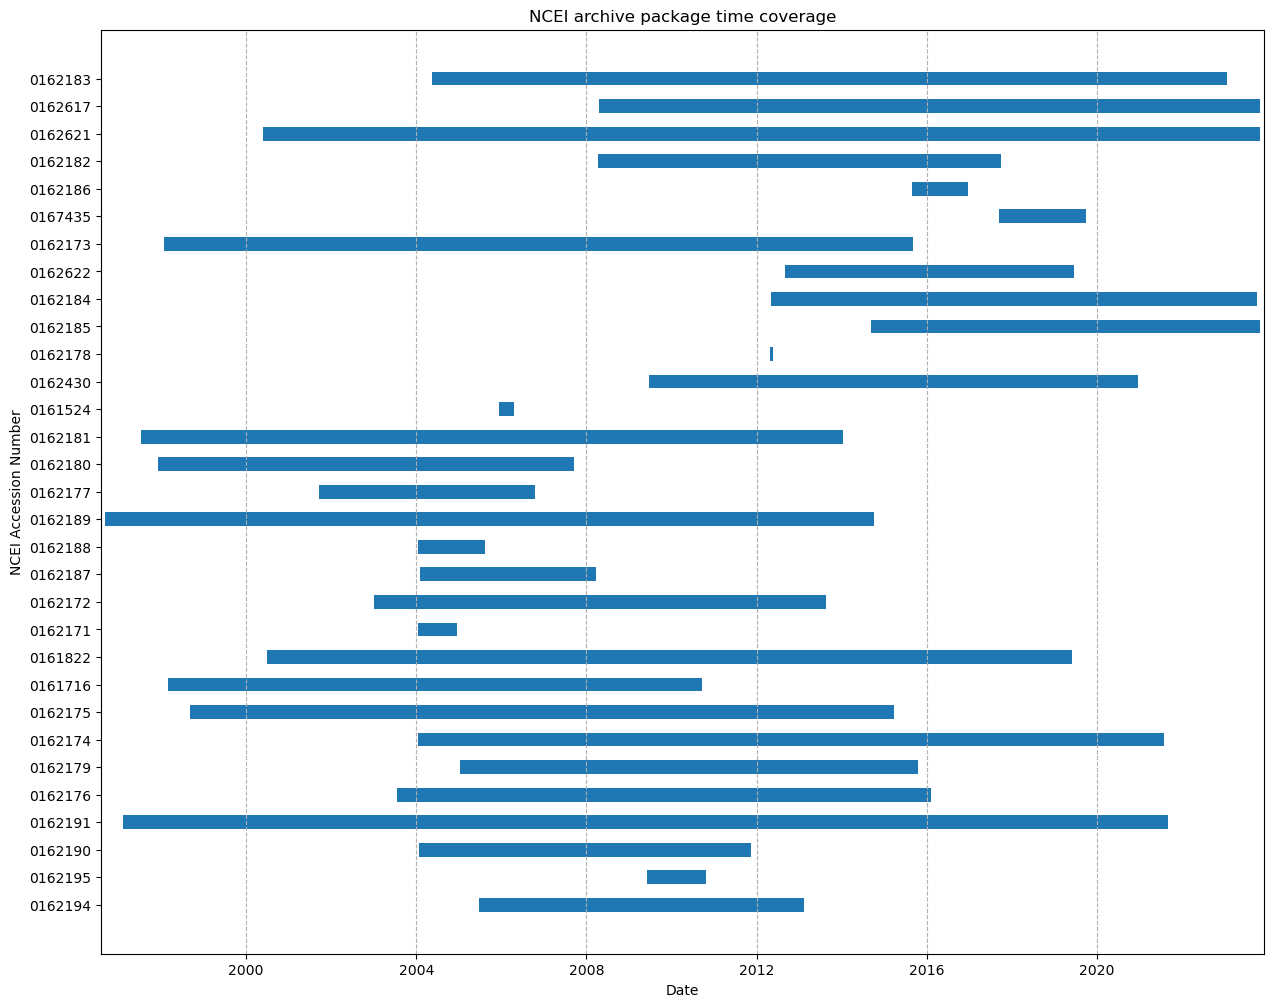

In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

ypos = range(len(df))
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the data
ax.barh(
    ypos,
    mdates.date2num(df["data_end_date"]) - mdates.date2num(df["data_start_date"]),
    left=mdates.date2num(df["data_start_date"]),
    height=0.5,
    align="center",
)

xlim = (
    mdates.date2num(df["data_start_date"].min() - pd.Timedelta(30, "d")),
    mdates.date2num(df["data_end_date"].max() + pd.Timedelta(30, "d")),
)

ax.set_xlim(xlim)
ax.set(yticks=np.arange(0, len(df)))
ax.tick_params(which="both", direction="out")
ax.set_ylabel("NCEI Accession Number")
ax.set_yticklabels(df["NCEI_accession_number"])
ax.set_title("NCEI archive package time coverage")

ax.xaxis_date()
ax.set_xlabel("Date")

ax.grid(axis="x", linestyle="--")

This procedure has been developed as an example of how to use NCEI's geoportal REST API's to collect information about packages that have been archived at NCEI. The intention is to provide some guidance and ways to collect this information without having to request it directly from NCEI. There are a significant amount of metadata elements which NCEI makes available through their ISO metadata records. Therefore, anyone interested in collecting other information from the records at NCEI should have a look at the ISO metadata records and determine which items are of interest to their community. Then, update the example code provided to collect that information.

**Author:** Mathew Biddle